# Statistical tests: primer

We're going to use [code and data](https://github.com/the-markup/investigation-isp) from "Still Loading" to run some statistical tests in Kansas City.

In [1]:
%load_ext autoreload
%autoreload 2

In [5]:
# !pip install statsmodels scipy

In [8]:
import pandas as pd
from statsmodels.stats.weightstats import ztest as ztest
from scipy.stats import ttest_ind

from aggregators import plot_race, redlining, bucket_and_bin

In [9]:
??bucket_and_bin

Signature: bucket_and_bin(df, limitations=False)
Source:   
def bucket_and_bin(df, limitations=False):
    """This is how we wrangle our data"""
    # These are our IVs
    # https://www.federalreserve.gov/consumerscommunities/cra_resources.htm
    df.loc[df['income_lmi'] < -100, 'income_lmi'] = None   
    df.loc[df['median_household_income'] == -666666666.0, 'median_household_income'] = None  
    
    df['income_level'] = aspirational_quartile(
        df['median_household_income'],
        labels=['Low', 'Middle-Lower', 'Middle-Upper', 'Upper Income'],
    ) 
    
    df['speed_down_bins'] = pd.cut(
        df.speed_down, 
        [-1, 0.00001, 25,  100, 200, 100000],
        labels=speed_labels,
        right=False
    )
 
    try:
        df['race_quantile'] = aspirational_quartile(
            df.race_perc_non_white, 
            labels=race_labels
        )
        
    except:
        print(df.major_city.iloc[0])
    
    if limitations:
        df['race_quantile'] = pd.cut(df

In [10]:
url = 'https://github.com/the-markup/investigation-isp/raw/main/data/output/speed_price_att.csv.gz'

In [11]:
df = pd.read_csv(url)

In [12]:
df.major_city.value_counts()

major_city
chicago          61228
houston          58293
los angeles      48336
jacksonville     30723
columbus         26505
detroit          26417
charlotte        24563
oklahoma city    20223
kansas city      18508
milwaukee        16504
new orleans      16471
indianapolis     16390
wichita          13787
atlanta          12919
louisville        9592
nashville         9542
little rock       6837
huntsville        6231
charleston        4699
jackson           4535
Name: count, dtype: int64

In [13]:
df.iloc[0]

address_full                       2406 Country Club Ave NW, Huntsville AL 35816
incorporated_place                                               Huntsville city
major_city                                                            huntsville
state                                                                         AL
lat                                                                    34.745179
lon                                                                   -86.606806
block_group                                                          10890007022
collection_datetime                                                   1650310200
provider                                                                    AT&T
speed_down                                                                 0.768
speed_up                                                                   0.384
speed_unit                                                                  Mbps
price                       

### Filter dataframe by a City of your choosing

In [14]:
city = 'kansas city'

In [15]:
df_city = df[df.major_city == city]

Split the dataframe into two groups based on the redlining grade. Merged from [Mapping Inequality](https://dsl.richmond.edu/panorama/redlining/).

Make sure `redlined` is just `D` grades and `non_redlined` is both `A` and `B` grades.

In [16]:
redlined = df_city[df_city.redlining_grade == 'D'].speed_down
non_redlined = df_city[df_city.redlining_grade.isin(['A', 'B'])].speed_down

Show some descriptive statistics. What is the median speed in each group, do the sizes of each group look comparable?

In [17]:
redlined.describe()

count    3058.000000
mean       34.733800
std        71.442268
min         0.000000
25%         0.768000
50%        10.000000
75%        18.000000
max       300.000000
Name: speed_down, dtype: float64

In [18]:
non_redlined.describe()

count    1306.000000
mean      201.381623
std       130.545752
min         0.000000
25%        50.000000
50%       300.000000
75%       300.000000
max       300.000000
Name: speed_down, dtype: float64

### Z test

In [21]:
z_score, p = ztest(redlined, non_redlined, value=0) 

In [22]:
z_score, p

(-54.12498026584233, 0.0)

The `p`-value is the second variable returned from `ztest`, the threshold for statistifcal significance is usually 0.05. Anything below that is significant! The p-value is the most important takeaway for the statistical test.

The first variable is a `z_score`. It shows how far away (in standard deviations) the mean of the second population (`non_redlined`) is from the mean of the first population (`redlined`). The negative/positive shows in what direction. 

In this case the mean speed for the redlined population is much less than the mean speed of the non-redlined population, and the difference is statistically significant.

### T-Test

Z and T-tests look about the same when your sample size is greater than 30.

In [23]:
t_score, p = ttest_ind(a = redlined, b = non_redlined)

In [24]:
t_score,p 

(-54.12498026584233, 0.0)

Interpret the results of the tests along with the descriptive statistics above.

Low `p`-value = statistical signifigance.

The `t_score` is unitless, but generally a large value denotes greater magnitude of difference between the mean of both populations.

## Race/Ethnicity

In [38]:
# divide the sample into tw groups: White and non-White using a fixed-threshold
white = df_city[df_city.race_perc_non_white <= .4].speed_down
non_white = df_city[df_city.race_perc_non_white > .6].speed_down

Get summary statistics for each group

In [39]:
white.describe()

count    9857.000000
mean       81.229850
std       103.126982
min         0.000000
25%        18.000000
50%        50.000000
75%        75.000000
max       300.000000
Name: speed_down, dtype: float64

In [40]:
non_white.describe()

count    6359.000000
mean       47.977540
std        81.839822
min         0.000000
25%         1.000000
50%        18.000000
75%        50.000000
max       300.000000
Name: speed_down, dtype: float64

Is the median download speed different across the groups? What are the median speeds?

Do the size of each group look comparable?

kansas city


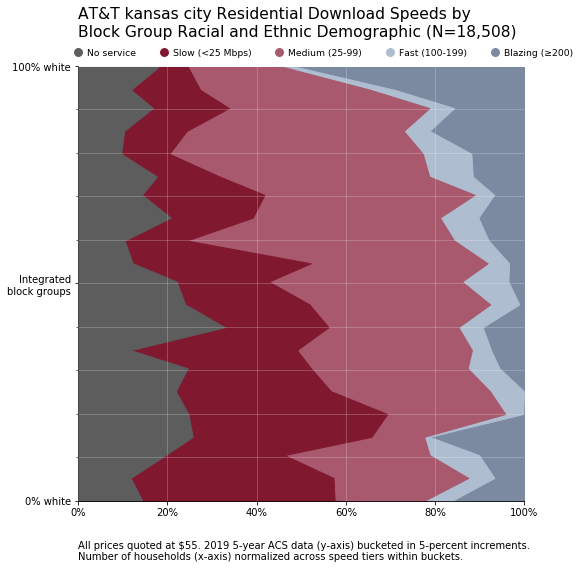

In [21]:
plot_race(bucket_and_bin(df_city), location=city)

Run a Z test and a T test.

In [18]:
ztest(white, 
      non_white,
      value=0) 

(21.682346978015534, 3.01126046991474e-104)

In [19]:
ttest_ind(a = white,
          b = non_white)

Ttest_indResult(statistic=21.682346978015534, pvalue=8.648484339326299e-103)

Which test is the better choice? Why?